# Libraries

In [1]:
import  pandas            as pd
import  numpy             as np
import  plotly.express    as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
import  plotly.io         as pio
from    datetime                import datetime
from    sklearn.decomposition   import PCA
from    sklearn.preprocessing   import StandardScaler
from    sklearn.ensemble        import RandomForestClassifier
from    xgboost                 import XGBClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import accuracy_score
from    sklearn.metrics         import confusion_matrix
from    sklearn.metrics         import precision_score
from    sklearn.metrics         import recall_score
from    sklearn.metrics         import f1_score
from    sklearn.metrics         import roc_auc_score
from    sklearn.metrics         import ConfusionMatrixDisplay
from    sklearn.metrics         import RocCurveDisplay

In [2]:
RANDOM_SEED = np.random.seed(31)

In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default


c:\Users\victo\Downloads\00. Estudo Data Science\predict_payment_default\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# df train

In [4]:
df_train = pd.read_csv('data\processed\df_train.csv',
                       encoding='utf-8',
                       sep=','
                      )
df_train['SAFRA_REF'] = pd.to_datetime(df_train['SAFRA_REF']).dt.to_period('M')
df_train['DATA_CADASTRO'] = pd.to_datetime(df_train['DATA_CADASTRO'])
df_train['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_train['DATA_EMISSAO_DOCUMENTO'])
df_train['DATA_PAGAMENTO'] = pd.to_datetime(df_train['DATA_PAGAMENTO'])
df_train['DATA_VENCIMENTO'] = pd.to_datetime(df_train['DATA_VENCIMENTO'])
df_train.head()

,ID_CLIENTE,SAFRA_REF,DATA_CADASTRO,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,IDADE_ANOS_CLIENTE,UF_DDD,UF_CEP,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMP,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,291490.683147,117.924537
1,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,0,291490.683147,117.924537
2,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,0,291490.683147,117.924537
3,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,1,291490.683147,117.924537
4,1661240395903230676,2018-08,2013-08-22,PF,Serviços,YAHOO,PEQUENO,11.0,MA,MA,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0,291490.683147,117.924537


In [6]:
df_train.dtypes

ID_CLIENTE                         int64
SAFRA_REF                      period[M]
DATA_CADASTRO             datetime64[ns]
FLAG_PF                           object
SEGMENTO_INDUSTRIAL               object
DOMINIO_EMAIL                     object
PORTE                             object
IDADE_ANOS_CLIENTE               float64
UF_DDD                            object
UF_CEP                            object
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
DIAS_ATRASO                        int64
INADIMP                            int64
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                  float64
dtype: object

In [7]:
df_train.isna().sum()

ID_CLIENTE                   0
SAFRA_REF                    0
DATA_CADASTRO                0
FLAG_PF                      0
SEGMENTO_INDUSTRIAL          0
DOMINIO_EMAIL                0
PORTE                        0
IDADE_ANOS_CLIENTE           0
UF_DDD                    9449
UF_CEP                       8
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
VALOR_A_PAGAR                0
TAXA                         0
DIAS_ATRASO                  0
INADIMP                      0
RENDA_MES_ANTERIOR           0
NO_FUNCIONARIOS              0
dtype: int64

# Dummies

In [8]:
columns_to_dummies = df_train.select_dtypes(exclude=['number']).columns
columns_to_dummies

Index(['SAFRA_REF', 'DATA_CADASTRO', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'UF_DDD', 'UF_CEP', 'DATA_EMISSAO_DOCUMENTO',
       'DATA_PAGAMENTO', 'DATA_VENCIMENTO'],
      dtype='object')

In [9]:
df_dummies = pd.get_dummies(df_train[columns_to_dummies],
                            drop_first=True, dtype=int)
df_dummies = df_dummies.select_dtypes(include=['number'])
df_dummies

,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,DOMINIO_EMAIL_GMAIL,DOMINIO_EMAIL_HOTMAIL,DOMINIO_EMAIL_OUTLOOK,DOMINIO_EMAIL_YAHOO,PORTE_MEDIO,PORTE_PEQUENO,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77409,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
77410,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77411,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77412,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [10]:
df_numeric_features = df_train.select_dtypes(include=['number']).drop(columns=['INADIMP', 'ID_CLIENTE'])
X_train_encoded = pd.concat([df_numeric_features, df_dummies], axis=1)
X_train_encoded.dropna(inplace=True)
X_train_encoded.head()

,IDADE_ANOS_CLIENTE,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,11.0,35516.41,6.99,0,291490.683147,117.924537,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,11.0,17758.21,6.99,1,291490.683147,117.924537,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,11.0,17431.96,6.99,1,291490.683147,117.924537,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,11.0,1341.00,6.99,6,291490.683147,117.924537,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,11.0,21309.85,6.99,0,291490.683147,117.924537,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_train = df_train['INADIMP'].iloc[X_train_encoded.index]
y_train

0        0
1        0
2        0
3        1
4        0
        ..
77409    1
77410    0
77411    0
77412    0
77413    0
Name: INADIMP, Length: 77414, dtype: int64

In [12]:
y_train.value_counts()

INADIMP
0    71978
1     5436
Name: count, dtype: int64

# Balance data

In [13]:
from    imblearn.over_sampling  import SMOTE

In [14]:
# Balance train data minority class
oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train_encoded, y_train)

SMOTE(sampling_strategy='minority')

In [15]:
# Data balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_encoded, y_train)

In [16]:
y_train_balanced.value_counts()

INADIMP
0    71978
1    71978
Name: count, dtype: int64

# Scale data

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_balanced)
X_train_scaled = scaler.transform(X_train_balanced)
X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train_balanced.columns,
                              index=X_train_balanced.index
                              )
X_train_scaled.dropna(inplace=True)
X_train_scaled.head()

,IDADE_ANOS_CLIENTE,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF_PJ,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,DOMINIO_EMAIL_BOL,...,UF_CEP_PE,UF_CEP_PI,UF_CEP_PR,UF_CEP_RJ,UF_CEP_RN,UF_CEP_RS,UF_CEP_SC,UF_CEP_SE,UF_CEP_SP,UF_CEP_TO
0,-0.561879,-0.060058,0.099879,-0.298445,0.105366,0.017405,-0.046154,-0.451427,1.257402,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228428,-0.034587,-0.226756,-0.18444,-0.037018,-0.362099,-0.070502
1,-0.561879,-0.343574,0.099879,-0.264276,0.105366,0.017405,-0.046154,-0.451427,1.257402,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228428,-0.034587,-0.226756,-0.18444,-0.037018,-0.362099,-0.070502
2,-0.561879,-0.348783,0.099879,-0.264276,0.105366,0.017405,-0.046154,-0.451427,1.257402,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228428,-0.034587,-0.226756,-0.18444,-0.037018,-0.362099,-0.070502
3,-0.561879,-0.605681,0.099879,-0.093431,0.105366,0.017405,-0.046154,-0.451427,1.257402,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228428,-0.034587,-0.226756,-0.18444,-0.037018,-0.362099,-0.070502
4,-0.561879,-0.286871,0.099879,-0.298445,0.105366,0.017405,-0.046154,-0.451427,1.257402,-0.135249,...,-0.155202,-0.086332,-0.262349,-0.228428,-0.034587,-0.226756,-0.18444,-0.037018,-0.362099,-0.070502


# PCA

In [18]:
pca = PCA()
pca.fit(X_train_scaled)

PCA()

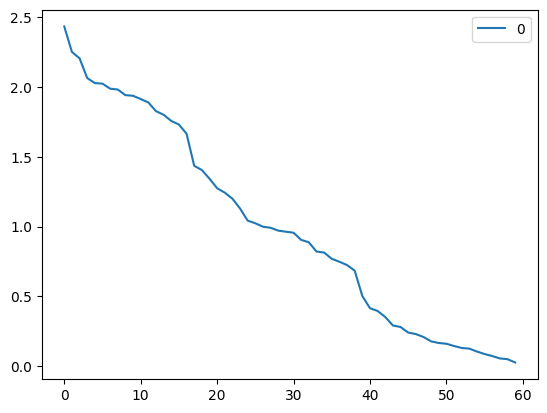

In [19]:
# Eigenvalues
df_explained_variance = pd.DataFrame(pca.explained_variance_)
df_explained_variance.plot()
plt.show()

In [20]:
# Eigenvector
df_components = pd.DataFrame(pca.components_)
df_components.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.302369,-0.028396,0.024563,0.058813,0.058484,0.074086,-0.002483,-0.204815,0.201618,-0.099172,...,-0.021490,0.013957,-0.088522,-0.025124,-0.015782,0.013675,-0.159623,0.012306,0.394129,-0.009787
1,0.020385,0.053746,-0.055244,-0.042360,0.019070,-0.253472,0.051152,0.012492,0.066482,-0.138124,...,0.021297,-0.014661,-0.034799,-0.038827,0.000492,0.061676,-0.043764,0.064113,0.030234,-0.002964
2,0.132339,0.071489,0.024126,-0.046389,0.029826,-0.066217,-0.059732,0.230821,-0.171343,-0.202105,...,0.069450,-0.023487,0.015280,0.044766,-0.010399,0.166768,-0.038124,-0.036993,0.154310,-0.006168
3,-0.070319,-0.052680,-0.019067,0.015157,-0.026713,-0.093619,0.027423,0.002634,0.103898,0.093728,...,-0.078027,-0.013180,-0.123251,-0.120716,-0.014330,-0.041233,-0.319531,0.014724,-0.088973,0.010992
4,-0.032526,-0.007766,0.008394,-0.018098,-0.003799,0.015675,0.003317,-0.094321,0.065595,-0.063275,...,-0.127711,-0.029266,0.052388,-0.076718,-0.013559,-0.081360,0.465812,-0.022720,-0.067743,0.016738


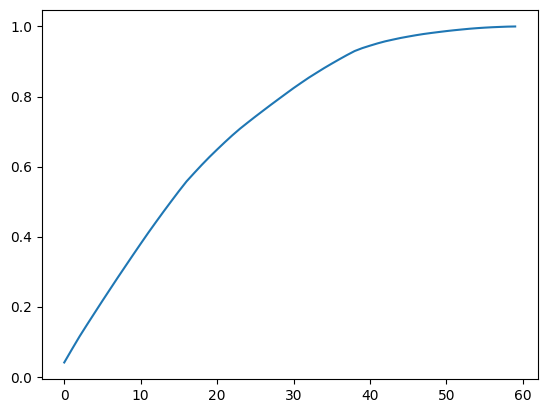

In [21]:
# Explained variance
df_explained_var_ratio = pd.DataFrame(pca.explained_variance_ratio_)
df_explained_var_ratio['cumsum'] = df_explained_var_ratio.cumsum()
df_explained_var_ratio['cumsum'].plot()
plt.show()

In [22]:
# N components for 90% explained variation ratio
n_components = df_explained_var_ratio[df_explained_var_ratio['cumsum'] >= 0.9].index[0]
n_components

36

In [23]:
pca_new = PCA(n_components=n_components)
pca_new.fit(X_train_scaled)
X_train_pca = pd.DataFrame(pca_new.transform(X_train_scaled))

# Rename columns to PC_number
[X_train_pca.rename(columns={col: f'PC_{i}'}, inplace=True) for i, col in enumerate(X_train_pca.columns, start=1)]
X_train_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36
0,-1.134491,1.036787,2.825269,3.468344,-0.190109,-2.048001,0.482332,0.087520,-3.165175,-1.002299,...,-1.061104,-0.761442,-1.843102,0.011119,-1.105167,-1.648982,-2.189306,3.210671,-0.077003,-1.153553
1,-1.124431,1.020101,2.803416,3.483798,-0.188526,-2.053986,0.488081,0.073003,-3.167616,-0.996512,...,-1.107457,-0.922139,-1.841907,-0.015590,-1.221709,-1.748188,-2.192644,3.229923,-0.038864,-1.060066
2,-1.124283,1.019821,2.803044,3.484072,-0.188485,-2.054039,0.488177,0.072751,-3.167637,-0.996385,...,-1.108241,-0.925246,-1.842041,-0.016113,-1.223841,-1.750118,-2.192605,3.230189,-0.038569,-1.058491
3,-1.106940,0.998777,2.776753,3.500195,-0.189582,-2.072072,0.495557,0.056352,-3.175137,-0.995762,...,-1.165333,-1.036557,-1.806245,-0.033026,-1.331330,-1.816145,-2.217887,3.267320,0.086475,-0.942011
4,-1.128050,1.024596,2.809055,3.480293,-0.188348,-2.050325,0.486507,0.076541,-3.166094,-0.996767,...,-1.095238,-0.896702,-1.848930,-0.011672,-1.198031,-1.733010,-2.187627,3.222226,-0.064174,-1.084972


# Functions

In [24]:
def plot_cross_validation_score(cv_results, score):
    """
    Plots the cross-validation scores for training and validation datasets.
    
    Parameters:
        cv_results (dict): A dictionary containing the cross-validation results.
                            It should have keys 'train_<score>' and 'test_<score>'.
        score (str): The metric to be plotted. For example, 'accuracy' or 'loss'.
    
    Returns: None
                This function displays a plot and does not return any value.
    """
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(range(1, len(cv_results[f'train_{score}'])))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

In [25]:
def calculate_feature_importance(model, importance):
    """
    Calculates and plots the feature importance from a model.
    
    Parameters:
        model: A trained model that has 'feature_importances_' and 'feature_names_in_' attributes.
                    Typically, this would be a tree-based model like RandomForest, GradientBoosting, etc.
        importance: The threshold below which feature importance are filtered out. 
    
    Returns:
        DataFrame: A DataFrame containing the features and their importance, sorted in ascending order and
                    filtered to show only features with importance greater than zero.
    
    This function performs the following steps:
        1. Extracts the feature importance from the model.
        2. Creates a DataFrame with features and their importance.
        3. Plots a boxplot of feature importance.
        4. Filters features with importance greater than zero.
        5. Plots a bar chart of features with non-zero importance.
    """
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature'   : model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)
    df_feat_importance.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    df_feat_importance_no_zero = df_feat_importance[df_feat_importance['importance'] > importance]
    plt.figure(figsize=(8, 10))
    plt.barh(df_feat_importance_no_zero['feature'], df_feat_importance_no_zero['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{df_feat_importance_no_zero.shape[0]} importance greater than {importance}')

    return df_feat_importance_no_zero

# Random forest

In [26]:
parameters_rf_clf = {
    "model_parameters": {
        "n_estimators": [30, 50],
        "criterion": ["gini"],
        "max_depth": [2, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 5,
        "folders": 5,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}

In [27]:
def create_hyper_parameters_rf_clf(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=5
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=2
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

## Simple model

In [28]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train_pca, y_train_balanced)

RandomForestClassifier()

### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.9755
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.8498
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9776
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.8776


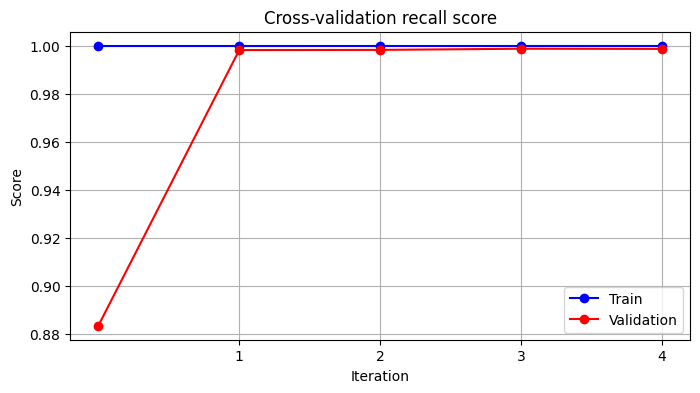

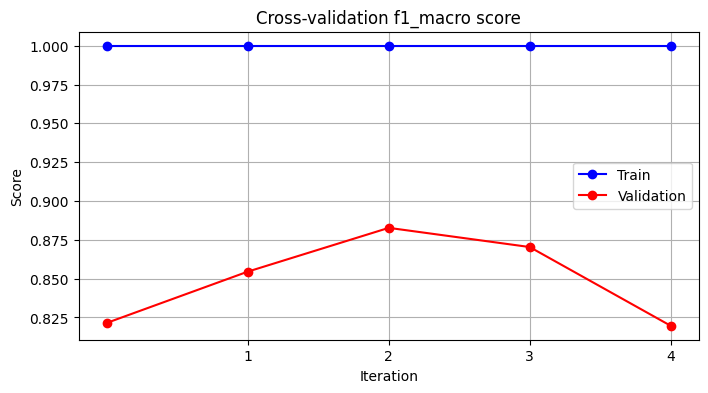

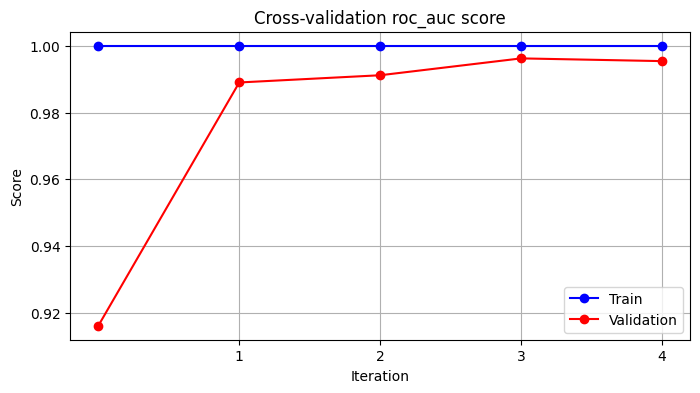

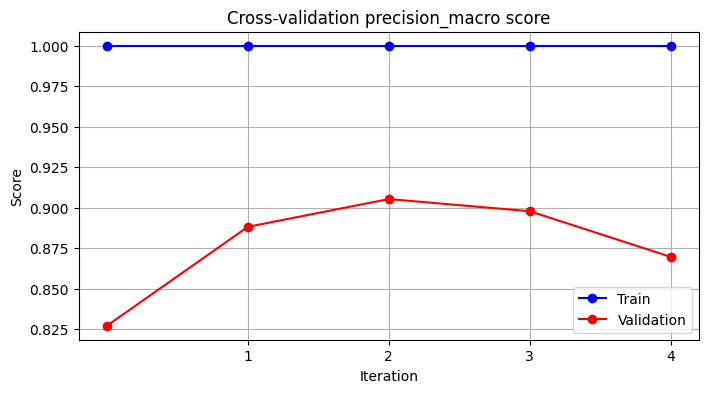

In [29]:
cv_results_rf_clf = cross_validate(estimator=rf_clf,
                                   X=X_train_pca,
                                   y=y_train_balanced,
                                   scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                   cv=parameters_rf_clf.get('cross_validation')['folders'],
                                   verbose=0,
                                   return_train_score=True,
                                   error_score=np.nan
                                   )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

## Tuning

In [30]:
param_dist_rf_clf = create_hyper_parameters_rf_clf(parameters_rf_clf)
param_dist_rf_clf

{'n_estimators': array([30, 35, 40, 45]),
 'max_depth': array([ 2,  4,  6,  8, 10, 12]),
 'min_samples_split': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'min_samples_leaf': array([1, 2, 3, 4, 5, 6])}

In [31]:
random_search_rf_clf = RandomizedSearchCV(estimator=rf_clf,
                                          param_distributions=param_dist_rf_clf,
                                          verbose=3,
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          n_iter=parameters_rf_clf.get('cross_validation')['n_iterations'],
                                          random_state=RANDOM_SEED,
                                          scoring=make_scorer(f1_score)
                                          )
random_search_rf_clf.fit(X_train_pca, y_train_balanced)

best_params_rf_clf = random_search_rf_clf.best_params_
rf_clf_tuning = RandomForestClassifier(**best_params_rf_clf, random_state=RANDOM_SEED)
rf_clf_tuning.fit(X_train_pca, y_train_balanced)
print(f'\nBest parameters:\n{best_params_rf_clf}\n')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=4, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.000 total time=   0.5s
[CV 2/5] END max_depth=4, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.000 total time=   0.4s
[CV 3/5] END max_depth=4, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.667 total time=   0.4s
[CV 4/5] END max_depth=4, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.667 total time=   0.4s
[CV 5/5] END max_depth=4, min_samples_leaf=2, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.667 total time=   0.3s
[CV 1/5] END max_depth=2, min_samples_leaf=4, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.667 total time=   0.4s
[CV 2/5] END max_depth=2, min_samples_leaf=4, min_samples_split=0.9000000000000001, n_estimators=30;, score=0.667 total time=   0.4s
[CV 3/5] 

### Cross-validation scores

>>>>>>>>> CV recall train mean: 0.7345
>>>>>>>>> CV recall test mean:  0.7324
>>>>>>>>> CV f1_macro train mean: 0.783
>>>>>>>>> CV f1_macro test mean:  0.7757
>>>>>>>>> CV roc_auc train mean: 0.8549
>>>>>>>>> CV roc_auc test mean:  0.8473
>>>>>>>>> CV precision_macro train mean: 0.7867
>>>>>>>>> CV precision_macro test mean:  0.7831


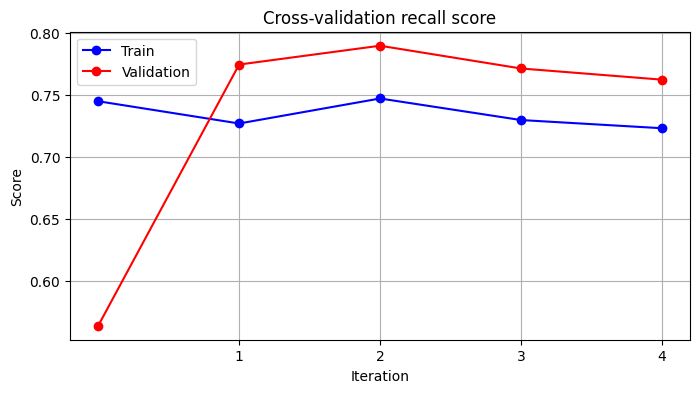

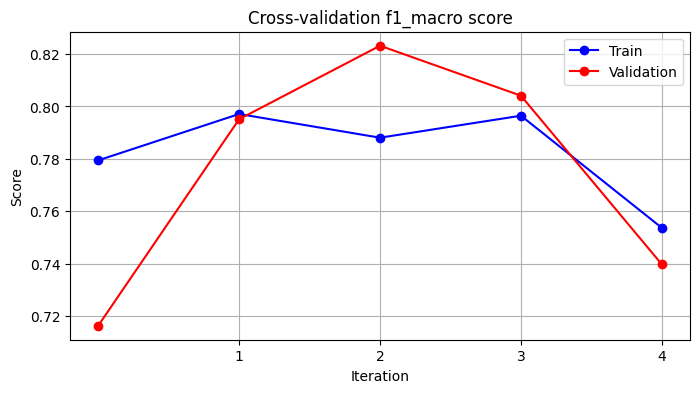

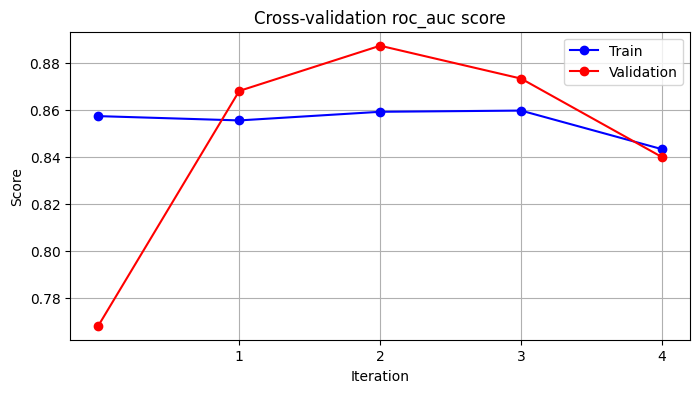

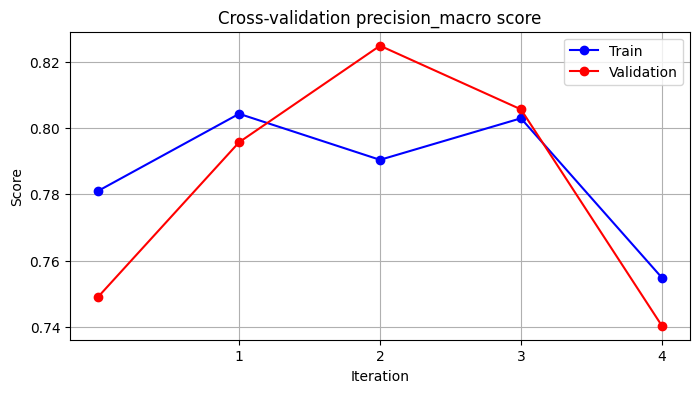

In [32]:
cv_results_rf_clf_tuning = cross_validate(estimator=rf_clf_tuning,
                                          X=X_train_pca,
                                          y=y_train_balanced,
                                          scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          verbose=0,
                                          return_train_score=True,
                                          error_score=np.nan
                                          )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_tuning[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf_tuning[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

### Feature importance

,feature,importance
25,PC_26,0.011029
26,PC_3,0.033333
27,PC_16,0.033333
28,PC_13,0.033333
29,PC_5,0.048522


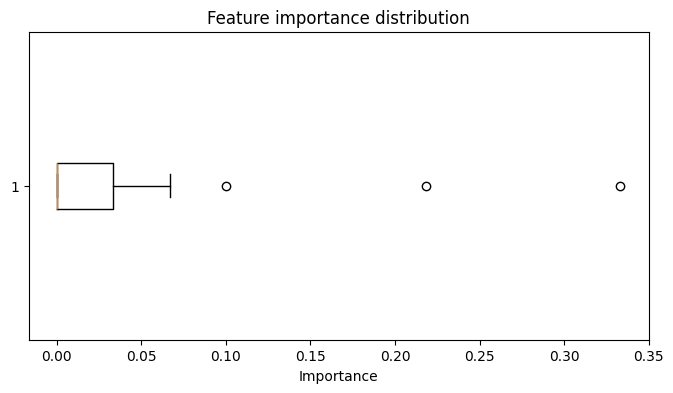

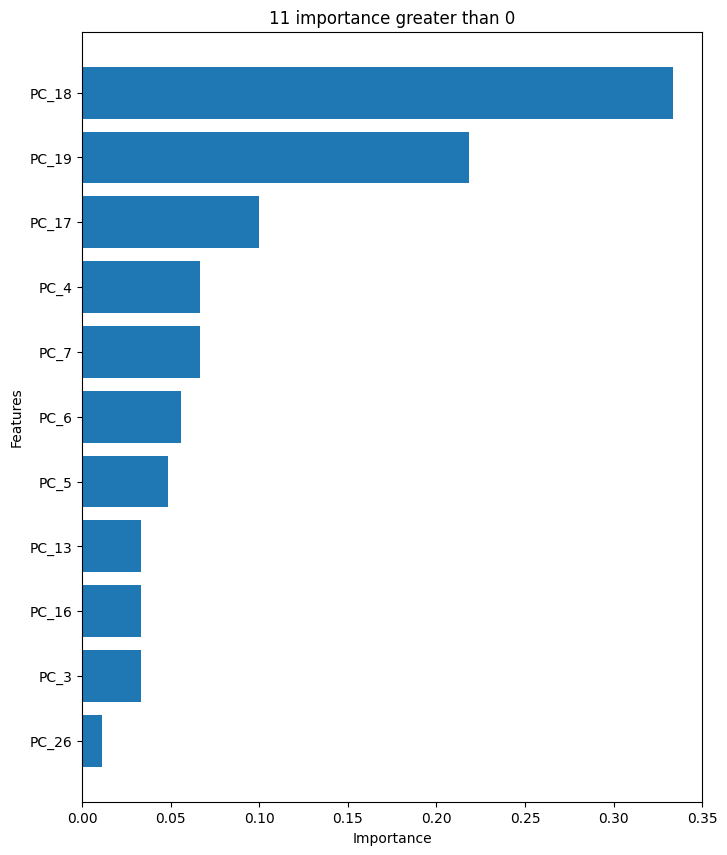

In [34]:
df_feat_importance_rf_clf = calculate_feature_importance(rf_clf_tuning, importance=0)
df_feat_importance_rf_clf.head()

In [ ]:
# important_features_rf_clf         = df_feat_importance_rf_clf['feature'].to_list()
# X_train_important_features_rf_clf = X_train_pca[important_features_rf_clf]

# rf_clf_tuning.fit(X_train_important_features_rf_clf, y_train_balanced)

# Predict